### Multi-input Autoencoder model on CTG dataset
- Load Data
- Preprocess Data
- Perform PCA on Data
- Divide Dataset in 2 smaller datasets of fewer features
- Define Multi-input Autoencoder Model
- Train Model
- Generate predictions for Train and Test Sets
- Perform PCA on Encoded Data
- Evaluate generated data on classification models

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Data
ctg_data = pd.read_csv('../CTGRawData.csv', sep=';')

In [4]:
# Preprocess Data
# Separate Features from labels (last column)
y = ctg_data['NSP']
X = ctg_data.drop('NSP',axis=1).iloc[:,:21]
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [5]:
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))

In [6]:
# Divide the dataset into 2 subsets with fewer features, approximately in half.
X_train_first = X_train_norm.iloc[:,:11]
X_train_second = X_train_norm.iloc[:,11:]
X_test_first = X_test_norm.iloc[:,:11]
X_test_second = X_test_norm.iloc[:,11:]

In [26]:
print(X_train_first.shape[1])

11


_____________________________
### PCA

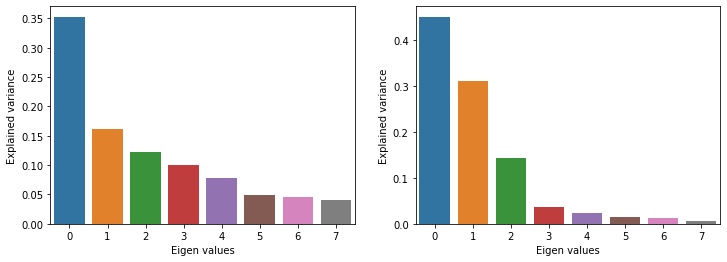

Simple PCA explained variance ratio: 0.9498474199178921
Simple PCA explained variance ratio: 0.9981328924281002


In [7]:
# Perform PCA to find the most significant features
from sklearn.decomposition import PCA
# select the number of components
pca_first = PCA(n_components = 8)
X_train_pca_first = pca_first.fit_transform(X_train_first)
X_test_pca_first = pca_first.transform(X_test_first)

pca_second = PCA(n_components = 8)
X_train_pca_second = pca_second.fit_transform(X_train_second)
X_test_pca_second = pca_second.transform(X_test_second)

x_pca_train_first_labeled = np.c_[X_train_pca_first , y_train]
x_pca_test_first_labeled = np.c_[X_test_pca_first , y_test]
x_pca_train_second_labeled = np.c_[X_train_pca_second , y_train]
x_pca_test_second_labeled = np.c_[X_test_pca_second , y_test]


plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sns.barplot(np.arange(np.shape(pca_first.explained_variance_ratio_)[0]),pca_first.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")

ax1 = plt.subplot(1,2,2)
sns.barplot(np.arange(np.shape(pca_second.explained_variance_ratio_)[0]),pca_second.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

print(f"Simple PCA explained variance ratio: {pca_first.explained_variance_ratio_.sum()}")
print(f"Simple PCA explained variance ratio: {pca_second.explained_variance_ratio_.sum()}")


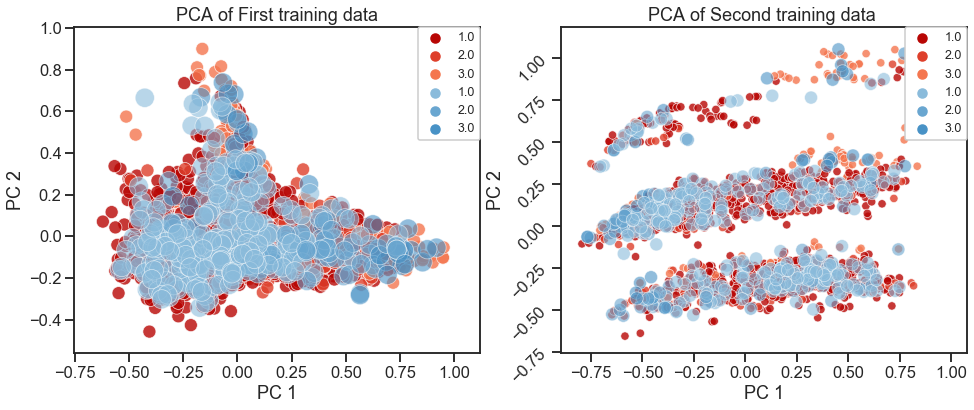

In [79]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=x_pca_train_first_labeled[:,0], 
                y=x_pca_train_first_labeled[:,1], 
                alpha = 0.8, 
                s= 170, legend='full', 
                hue=x_pca_train_first_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=x_pca_test_first_labeled[:,0],
                y=x_pca_test_first_labeled[:,1],
                alpha = 0.6, 
                s= 370, 
                legend='full',
                hue=x_pca_test_first_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of First training data")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x=x_pca_train_second_labeled[:,0], 
                y=x_pca_train_second_labeled[:,1], 
                alpha = 0.8, 
                s= 70, legend='full', 
                hue=x_pca_train_second_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=x_pca_test_second_labeled[:,0],
                y=x_pca_test_second_labeled[:,1],
                alpha = 0.6, 
                s= 170, 
                legend='full',
                hue=x_pca_test_second_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of Second training data ")

plt.yticks(rotation=45) 
plt.show()

__________________________________________
### Autoencoder

In [91]:
from typing import Tuple

# ToDo: Regularization L1 and L2. Configure Early Stopping 
# Define de multi-input multi-output model using the keras functional API
def build_multi_autoencoder(encoding_dim: int, number_features: Tuple, regularizer: tf.keras.regularizers.Regularizer):
    """Two-input autoencoder build function
       Parameters: encoding_dim: Size of the latent space (bottleneck layer size).
                   number_features: Tuple with the sizes of the two inputs.
                   regularizer: keras regularizer object
       Returns the 3 models: full autoencoder, the encoder part and the decoder part
    """
    # this is the reduction of our encoded representations, in times.
    print(f"Compression: {sum(number_features)/encoding_dim}")

    ## First Dataset input path
    # first input placeholder.
    first_input = layers.Input(shape=(number_features[0]))
    # first path hidden layer
    first_encoder = layers.Dense(encoding_dim/2, activation='relu', kernel_regularizer=regularizer)(first_input)

    ## Second Dataset input path
    # second input placeholder
    second_input = layers.Input(shape=(number_features[1]))
    # second path hidden layer
    second_encoder = layers.Dense(encoding_dim/2, activation='relu', kernel_regularizer=regularizer)(second_input)

    ## Concatenate paths - Bottleneck 
    bottleneck = layers.concatenate([first_encoder, second_encoder], axis=-1)

    # this model maps an input to its encoded representation
    encoder = keras.models.Model([first_input,second_input], bottleneck, name='encoder')

    ## Decoder Outputs
    encoded_input = layers.Input(shape=(encoding_dim,))
    ## First Dataset output path
    # first output hidden layer
    first_decoder = layers.Dense(8, activation='relu', kernel_regularizer=regularizer)(encoded_input)
    # first path decoded, reconstruction layer
    first_decoded = layers.Dense(number_features[0], activation='sigmoid')(first_decoder)

    ## Second path output hidden
    # second output hidden layer
    second_decoder = layers.Dense(8, activation='relu', kernel_regularizer=regularizer)(encoded_input)
    # second path decoded, reconstruction layer
    second_decoded = layers.Dense(number_features[1], activation='sigmoid')(second_decoder)

    # create the decoder model
    decoder = keras.models.Model(encoded_input, [first_decoded, second_decoded])

    # create the full autoencoder
    encoder_model = encoder([first_input, second_input])
    decoder_model = decoder(encoder_model)

    autoencoder = keras.models.Model([first_input,second_input], decoder_model, name="autoencoder")
    
    return autoencoder, encoder, decoder

In [136]:
## Call autoencoder build function and get the AE, the encoder and the decoder.
autoencoder, encoder, decoder = build_multi_autoencoder(8, (X_train_first.shape[1],X_train_second.shape[1]), tf.keras.regularizers.l2(1))
# Set Optimizer: Adam with learning rate=0.001
optimizer = tf.keras.optimizers.Adam(0.001)
# Set Early Stop Callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)
# Compile the autoencoder using Mean Square Error loss function for both inputs.
autoencoder.compile(optimizer=optimizer,
                        loss=["mse","mse"],
                        metrics=['mse'])

Compression: 2.625


In [11]:
autoencoder.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 8)            92          input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model (Model)                   [(None, 11), (None,  333         encoder[1][0]          

Epoch 00051: early stopping


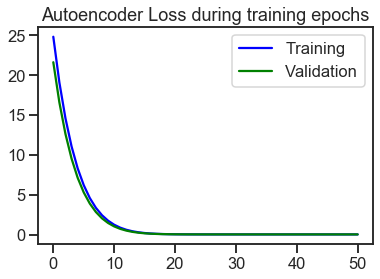

In [137]:
history = autoencoder.fit([X_train_first, X_train_second],[X_train_first, X_train_second],
                          validation_data=([X_test_first,X_test_second],[X_test_first,X_test_second]),
                          epochs=1000,
                          verbose=0,
                         callbacks=[early_stop])

plt.plot(history.history["loss"], c = 'b', label = "Training")
plt.plot(history.history["val_loss"], c = 'g', label = "Validation")
plt.title("Autoencoder Loss during training epochs")
plt.legend()
plt.show()

# l2 c=0.001 -> 
# l2 c=0.01 -> 0.057
# l2 c=0.1 -> 0.057
# l2 c=1 -> 0.057

In [138]:
history.history["val_loss"][-1]
history.history["loss"][-1]

0.05733518104342853

In [139]:
## Encode datasets
X_train_encoded = encoder.predict([X_train_first, X_train_second])
X_test_encoded = encoder.predict([X_test_first, X_test_second])

In [140]:
## Renormalize data
# Renormalize input
scaler = MinMaxScaler()
X_train_encoded = pd.DataFrame(scaler.fit_transform(X_train_encoded))
X_test_encoded = pd.DataFrame(scaler.transform(X_test_encoded))

______________________________________
### PCA on encoded data

In [141]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_encoded)
X_test_pca = pca.transform(X_test_encoded)

X_train_pca_labeled = np.c_[X_train_pca , y_train]
X_test_pca_labeled = np.c_[X_test_pca , y_test]

Simple PCA explained variance ratio: 1.0000000000000064


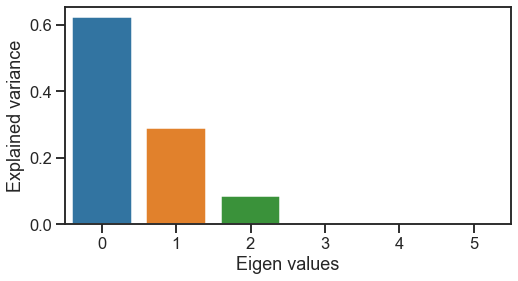

In [142]:
plt.figure(figsize=(8, 4))
sns.barplot(np.arange(np.shape(pca.explained_variance_ratio_)[0]),pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")

print(f"Simple PCA explained variance ratio: {pca.explained_variance_ratio_.sum()}")

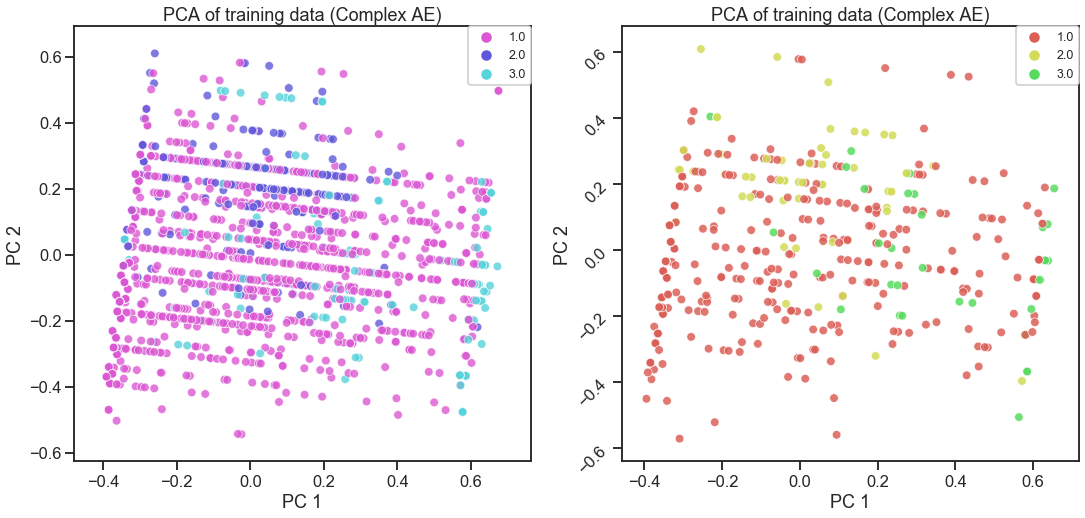

In [143]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=X_train_pca_labeled[:,0], 
                y=X_train_pca_labeled[:,1], 
                alpha = 0.8, 
                s= 75, legend='full', 
                hue=X_train_pca_labeled[:,-1],
                palette=sns.color_palette("hls")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (20,10) )
ax1.set_title("PCA of training data")


ax1 = plt.subplot(1,2,2)
sns.scatterplot(x=X_test_pca_labeled[:,0],
                y=X_test_pca_labeled[:,1],
                alpha = 0.85, 
                s= 75, 
                legend='full',
                hue=X_test_pca_labeled[:,-1], 
                palette=sns.color_palette("hls")[:3])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (18,8) )
ax1.set_title("PCA of test data")

plt.yticks(rotation=45) 
plt.show()

______________________
### DNN Classifier

In [104]:
# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

In [105]:
## Test the encoded input on the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(penalization: int, input_shape):
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization), input_shape=(input_shape,)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(64,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [ ]:
# Fit best model with original dimension data
best_model = build_best_model(0.00001, len(X_train_norm.keys()))
history = best_model.fit(X_train_norm, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist = pd.DataFrame(history.history)

test_loss, test_acc = best_model.evaluate(X_test_norm, y_test_oh)

# Fit best model with reduced dimension data
encoded_model = build_best_model(0.00001, len(X_train_encoded.keys()))
history_encoded = encoded_model.fit(X_train_encoded, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist_encoded = pd.DataFrame(history_encoded.history)

test_loss, test_acc = encoded_model.evaluate(X_test_encoded, y_test_oh)

In [86]:
X_train_encoded

(1700, 21)